In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import tqdm
import random
import datetime
from sklearn.metrics import mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

In [16]:
### Quantile Regression Loss function
### https://towardsdatascience.com/deep-quantile-regression-c85481548b5a


### https://towardsdatascience.com/anomaly-detection-with-lstm-in-keras-8d8d7e50ab1b


![alt text](Capture.PNG "Quantile Regression Loss function")

In [2]:
### READ DATA AND CREATE FEATURES FOR year, month, day, hour ###

df = pd.read_csv('nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['yr'] = df.timestamp.dt.year
df['mt'] = df.timestamp.dt.month
df['d'] = df.timestamp.dt.day
df['H'] = df.timestamp.dt.hour

print(df.shape)
df.head()

(10320, 6)


,timestamp,value,yr,mt,d,H
0,2014-07-01 00:00:00,10844,2014,7,1,0
1,2014-07-01 00:30:00,8127,2014,7,1,0
2,2014-07-01 01:00:00,6210,2014,7,1,1
3,2014-07-01 01:30:00,4656,2014,7,1,1
4,2014-07-01 02:00:00,3820,2014,7,1,2


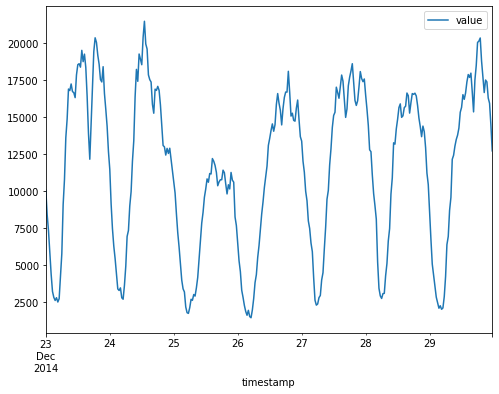

In [3]:
### PLOT SAMPLE OF DATA ###

df.iloc[8400:8400+7*48,:].plot(y='value', x='timestamp', figsize=(8,6))

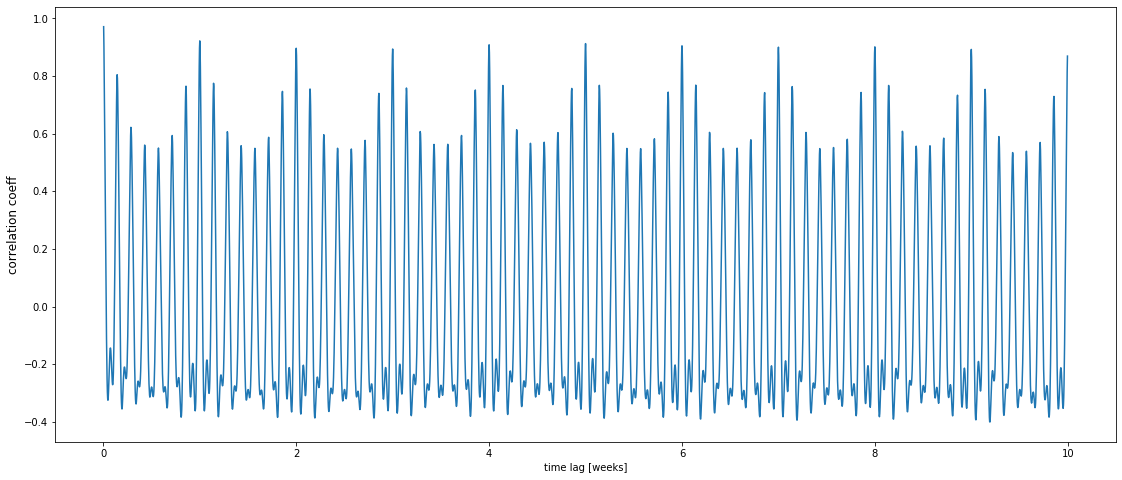

In [4]:
### WEEKLY AUTOCORR PLOT (10 WEEKS DEPTH) ###

timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]

plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);

In [5]:
timeLags

array([   1,    2,    3, ..., 3357, 3358, 3359])

In [6]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###

df['weekday'] = df.timestamp.dt.weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['value'].mean().to_dict())

In [7]:
df.head()

,timestamp,value,yr,mt,d,H,weekday,weekday_hour,m_weekday
0,2014-07-01 00:00:00,10844,2014,7,1,0,1,1 0,8774.433333
1,2014-07-01 00:30:00,8127,2014,7,1,0,1,1 0,8774.433333
2,2014-07-01 01:00:00,6210,2014,7,1,1,1,1 1,5242.933333
3,2014-07-01 01:30:00,4656,2014,7,1,1,1,1 1,5242.933333
4,2014-07-01 02:00:00,3820,2014,7,1,2,1,1 2,3170.433333


In [8]:
### CREATE GENERATOR FOR LSTM ###

sequence_length = 48

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [9]:
### CREATE AND STANDARDIZE DATA FOR LSTM ### 

cnt, mean = [], []
for sequence in gen_index(df, sequence_length, ['value']):
    cnt.append(sequence)
    
for sequence in gen_index(df, sequence_length, ['m_weekday']):
    mean.append(sequence)

cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean
cnt.shape

(10272, 48, 1)

In [10]:
cnt[0]

array([[ 0.21176974],
       [-0.07665034],
       [ 0.16927976],
       [-0.11872443],
       [ 0.18638215],
       [-0.0985115 ],
       [ 0.1279549 ],
       [-0.00986718],
       [ 0.06076158],
       [ 0.0319859 ],
       [-0.27576241],
       [ 0.27535386],
       [-0.31295381],
       [ 0.21268645],
       [-0.1217379 ],
       [ 0.013587  ],
       [-0.06526196],
       [ 0.06170496],
       [ 0.0526743 ],
       [ 0.08132985],
       [ 0.12053255],
       [ 0.05162997],
       [ 0.03573042],
       [ 0.10374497],
       [ 0.07507072],
       [ 0.07390651],
       [ 0.04419599],
       [ 0.11229361],
       [ 0.05461262],
       [ 0.10669604],
       [ 0.11695521],
       [ 0.07285989],
       [ 0.13206528],
       [ 0.05424363],
       [-0.03764775],
       [ 0.08896416],
       [-0.00637027],
       [ 0.17735817],
       [ 0.09583168],
       [ 0.02145127],
       [ 0.01188381],
       [-0.10292006],
       [ 0.0156265 ],
       [ 0.05902796],
       [ 0.08912669],
       [ 0

In [11]:
### CREATE AND STANDARDIZE LABEL FOR LSTM ###

init = df.m_weekday[sequence_length:].apply(np.log).values
label = df.value[sequence_length:].apply(np.log).values - init
label.shape

(10272,)

In [12]:
### DEFINE QUANTILE LOSS ###

def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [13]:
### TRAIN TEST SPLIT ###

X_train, X_test = cnt[:5000], cnt[5000:]
y_train, y_test = label[:5000], label[5000:]
train_date, test_date = df.timestamp.values[sequence_length:5000+sequence_length], df.timestamp.values[5000+sequence_length:]

In [ ]:
tf.random.set_random_seed

In [15]:
tf.random.set_random_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


### CREATE MODEL ###
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)
model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
model.fit(X_train, [y_train,y_train,y_train], epochs=50, batch_size=128, verbose=2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5000 samples
Epoch 1/50
5000/5000 - 18s - loss: 0.0292 - dense_1_loss: 0.0276 - dense_2_loss: 0.0450 - dense_3_loss: 0.0245
Epoch 2/50
5000/5000 - 16s - loss: 0.0268 - dense_1_loss: 0.0242 - dense_2_loss: 0.0425 - dense_3_loss: 0.0217
Epoch 3/50
5000/5000 - 16s - loss: 0.0262 - dense_1_loss: 0.0239 - dense_2_loss: 0.0423 - dense_3_loss: 0.0216
Epoch 4/50
5000/5000 - 15s - loss: 0.0258 - dense_1_loss: 0.0230 - dense_2_loss: 0.0411 - dense_3_loss: 0.0212
Epoch

In [17]:
### QUANTILEs BOOTSTRAPPING ###

pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model.layers[0].input], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    
    predd = NN([X_test, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:06<00:00,  3.06s/it]


In [18]:
### REVERSE TRANSFORM PREDICTIONS ###

pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[5000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[5000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[5000:])

In [19]:
### EVALUATION METRIC ###

mean_squared_log_error(np.exp(y_test + init[5000:]), pred_50_m)

0.045055708153501746

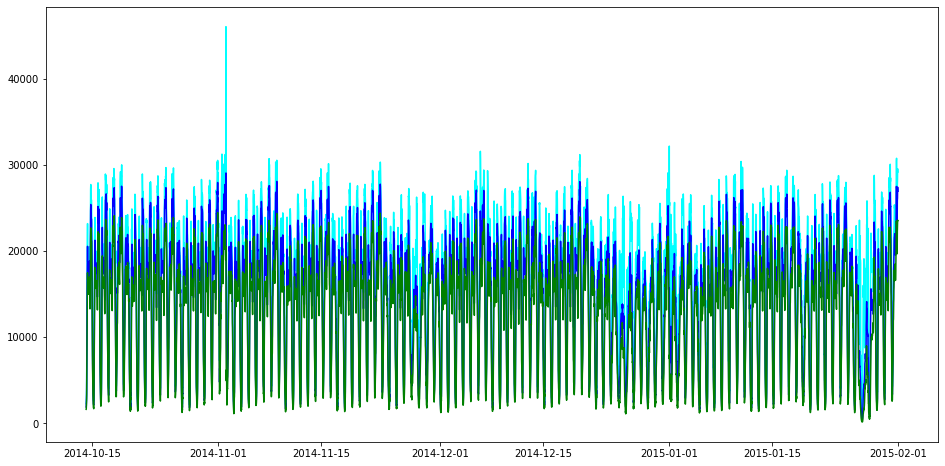

In [20]:
### PLOT QUANTILE PREDICTIONS ###

plt.figure(figsize=(16,8))
plt.plot(test_date, pred_90_m, color='cyan')
plt.plot(test_date, pred_50_m, color='blue')
plt.plot(test_date, pred_10_m, color='green')


### CROSSOVER CHECK ###

plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)

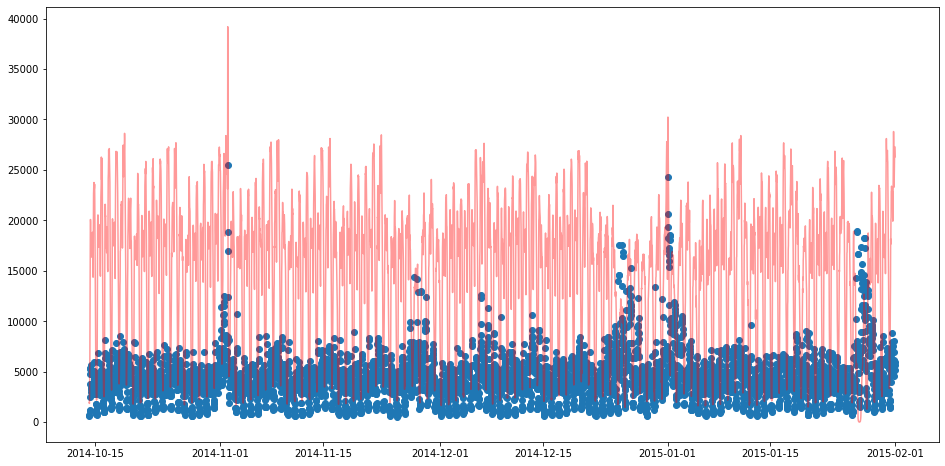

In [21]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###

plt.figure(figsize=(16,8))
plt.plot(test_date, np.exp(y_test + init[5000:]), color='red', alpha=0.4)
plt.scatter(test_date, pred_90_m - pred_10_m)